#Plotting Velocities and Tracers on Vertical Planes

This notebook contains discussion, examples, and best practices for plotting velocity field and tracer results from NEMO on vertical planes.
Topics include:

* Plotting colour meshes of velocity on vertical sections through the domain
* Using `nc_tools.timestamp()` to get time stamps from results datasets
* Plotting salinity as a colour mesh on thalweg section

We'll start with the usual imports, and activation of the Matplotlib inline backend:

In [1]:
from __future__ import division, print_function

import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np

from salishsea_tools import (
    nc_tools,
    viz_tools,
)

In [2]:
%matplotlib inline

Let's look at the results from the 17-Dec-2003 to 26-Dec-2003 spin-up run.
We'll also load the bathymetry so that we can plot land masks.

In [3]:
u_vel = nc.Dataset('/ocean/dlatorne/MEOPAR/SalishSea/results/spin-up/17dec26dec/SalishSea_1d_20031217_20031226_grid_U.nc')
v_vel = nc.Dataset('/ocean/dlatorne/MEOPAR/SalishSea/results/spin-up/17dec26dec/SalishSea_1d_20031217_20031226_grid_V.nc')

In [4]:
ugrid = u_vel.variables['vozocrtx']
vgrid = v_vel.variables['vomecrty']
zlevels = v_vel.variables['depthv']
timesteps = v_vel.variables['time_counter']

In [5]:
grid = nc.Dataset('/data/dlatorne/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')

##Velocity Component Colour Mesh on a Vertical Plane

There's really not much new involved in plotting on vertical planes
compared to the horizontal plane plots that we've done in the previous notebooks.
Here's are plots of the v velocity component crossing a vertical plane
defined by a section line running from just north of Howe Sound
to a little north of Nanaimo,
and the surface current streamlines in the area
with the section line shown for orientation.

Things to note:

* The use of the `invert_yaxis()` method on the vertical plane y-axis
to make the depth scale go from 0 at the surface to positive depths below,
and the resulting reversal of the limit values passed to the `set_ylim()` method
* The use of the `set_axis_bgcolor()` method to make the extension of the axis area
below the maximum depth appear consistent with the rest of the non-water regions

/home/mdunn/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


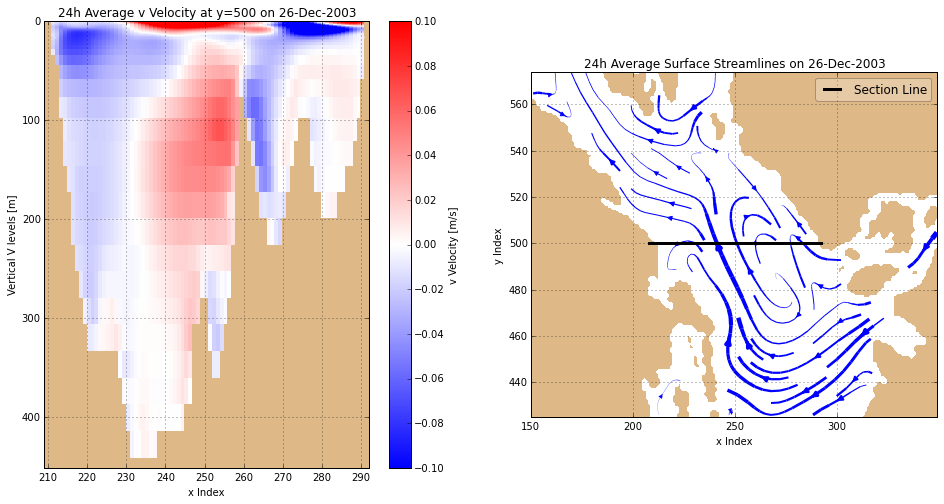

In [6]:
fig, (axl, axr) = plt.subplots(1, 2, figsize=(16, 8))
land_colour = 'burlywood'

# Define the v velocity component slice to plot
t, zmax, ylocn = -1, 41, 500
section_slice = np.arange(208, 293)
timestamp = nc_tools.timestamp(v_vel, t)

# Slice and mask the v array
vgrid_tzyx = np.ma.masked_values(vgrid[t, :zmax, ylocn, section_slice], 0)

# Plot the v velocity colour mesh
cmap = plt.get_cmap('bwr')
cmap.set_bad(land_colour)
mesh = axl.pcolormesh(
    section_slice[:], zlevels[:zmax], vgrid_tzyx,
    cmap=cmap, vmin=-0.1, vmax=0.1,
)
axl.invert_yaxis()
cbar = fig.colorbar(mesh, ax=axl)
cbar.set_label('v Velocity [{.units}]'.format(vgrid))

# Axes labels and title
axl.set_xlabel('x Index')
axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.set_title(
    '24h Average v Velocity at y={y} on {date}'
    .format(y=ylocn, date=timestamp.format('DD-MMM-YYYY')))

# Axes limits and grid
axl.set_xlim(section_slice[1], section_slice[-1])
axl.set_ylim(zlevels[zmax - 2] + 10, 0)
axl.set_axis_bgcolor(land_colour)
axl.grid()

# Define surface current magnitude slice
x_slice = np.arange(150, 350)
y_slice = np.arange(425, 575)

# Slice and mask the u and v arrays
ugrid_tzyx = np.ma.masked_values(ugrid[t, 0, y_slice, x_slice], 0)
vgrid_tzyx = np.ma.masked_values(vgrid[t, 0, y_slice, x_slice], 0)

# "Unstagger" the velocity values by interpolating them to the T-grid points
# and calculate the surface current speeds
u_tzyx, v_tzyx = viz_tools.unstagger(ugrid_tzyx, vgrid_tzyx)
speeds = np.sqrt(np.square(u_tzyx) + np.square(v_tzyx))
max_speed = viz_tools.calc_abs_max(speeds)

# Plot section line on surface streamlines map
viz_tools.set_aspect(axr)
axr.streamplot(
    x_slice[1:], y_slice[1:], u_tzyx, v_tzyx,
    linewidth=7*speeds/max_speed,
)
viz_tools.plot_land_mask(
    axr, grid, xslice=x_slice, yslice=y_slice, color=land_colour)
axr.plot(
    section_slice, ylocn*np.ones_like(section_slice),
    linestyle='solid', linewidth=3, color='black',
    label='Section Line',
)

# Axes labels and title
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
axr.set_title(
    '24h Average Surface Streamlines on {date}'
    .format(date=timestamp.format('DD-MMM-YYYY')))
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)

# Axes limits and grid
axr.set_xlim(x_slice[0], x_slice[-1])
axr.set_ylim(y_slice[0], y_slice[-1])
axr.grid()

The code above uses the `nc_tools.timestamp()` function
to obtain the time stamp of the plotted results from the dataset
and formats that value as a date in the axes titles.
Documentation for `nc_tools.timestamp()`
(and the other functions in the `nc_tools` module) is available
at http://salishsea-meopar-tools.readthedocs.org/en/latest/SalishSeaTools/salishsea-tools.html#nc_tools.timestamp
and via shift-TAB or the `help()` command in notebooks:

In [7]:
help(nc_tools.timestamp)

Help on function timestamp in module salishsea_tools.nc_tools:

timestamp(dataset, tindex)
    Return the time stamp of the tindex time_counter value(s) in dataset.
    
    The time stamp is calculated by adding the time_counter[tindex] value
    (in seconds) to the dataset's time_counter.time_origin value.
    
    :arg dataset: netcdf dataset object
    :type dataset: :py:class:`netCDF4.Dataset`
    
    :arg tindex: time_counter variable index.
    :type tindex: int or list
    
    :returns: Time stamp value(s) at tindex in the dataset.
    :rtype: :py:class:`Arrow` instance or list of instances



Passing a tuple or list of time indices;
e.g. `[0, 3, 6, 9]`,
to `nc_tools.timestamp()` causes a list of time stamp values to be returned
The time stamp value(s) returned are [Arrow](http://crsmithdev.com/arrow/) instances.
The `format()` method can be used to produce a string representation of
a time stamp,
for example:

In [8]:
timestamp.format('YYYY-MM-DD HH:mm:ss')

'2003-12-26 12:00:00'

NEMO results are calculated using the UTC time zone
but `Arrow` time stamps can easily be converted to other time zones:

In [9]:
timestamp.to('Canada/Pacific')

<Arrow [2003-12-26T04:00:00-08:00]>

Please see the [Arrow](http://crsmithdev.com/arrow/) docs for other useful methods
and ways of manipulating dates and times in Python.

##Salinity Colour Mesh on Thalweg Section



For this plot we'll look at results from the spin-up run that includes 27-Sep-2003
because it shows deep water renewal in the Strait of Georgia.

In [10]:
tracers = nc.Dataset('/ocean/dlatorne/MEOPAR/SalishSea/results/spin-up/18sep27sep/SalishSea_1d_20030918_20030927_grid_T.nc')

The salinity netCDF4 variables needs to be changed to a NumPy array.

In [11]:
sal = tracers.variables['vosaline']
npsal = sal[:]
zlevels = tracers.variables['deptht']

The thalweg is a line that connects the deepest points
of successive cross-sections through the model domain.
The grid indices of the thalweg are calculated in the
[compute_thalweg.ipynb](http://nbviewer.ipython.org/urls/bitbucket.org/salishsea/tools/raw/tip/analysis_tools/compute_thalweg.ipynb)
notebook and stored as `(j, i)` ordered pairs in the
`tools/analysis_tools/thalweg.txt/thalweg.txt` file:

In [12]:
!head thalweg.txt

405 2
404 3
404 4
404 5
404 6
404 7
403 8
403 9
402 10
401 11


We use the NumPy `loadtxt()` function to read the thalweg points
into a pair of arrays.
The `unpack` argument causes the result to be transposed from an
array of ordered pairs to arrays of `j` and `i` values.

In [13]:
thalweg = np.loadtxt('/data/dlatorne/MEOPAR/tools/bathymetry/thalweg_working.txt', dtype=int, unpack=True)

Plotting salinity along the thalweg is an example of plotting
a model result quantity on an arbitrary section through the domain.

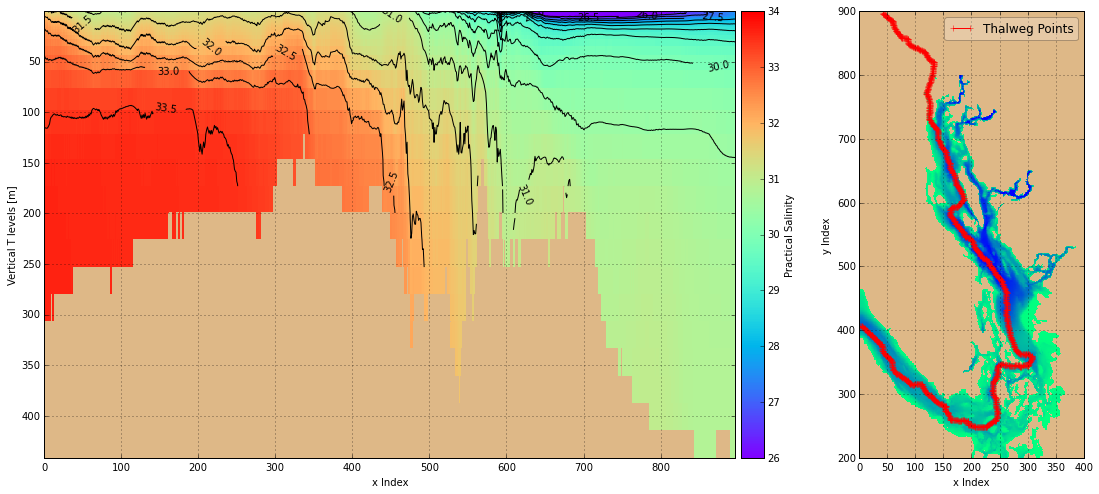

In [20]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap('winter_r')
cmap.set_bad(land_colour)
bathy = grid.variables['Bathymetry']
x_slice = np.arange(bathy.shape[1])
y_slice = np.arange(200, 800)
axr.pcolormesh(x_slice, y_slice, bathy[y_slice, x_slice], cmap=cmap)
axr.plot(
    thalweg[1], thalweg[0],
    linestyle='-', marker='+', color='red',
    label='Thalweg Points',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = -1  # 27-Dec-2003
smin, smax, dels = 26, 34, 0.5
cmap = plt.get_cmap('rainbow')
cmap.set_bad(land_colour)
sal_0 = npsal[t, :, thalweg[0], thalweg[1]]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(np.arange(thalweg.shape[1]), zlevels)
mesh = axl.pcolormesh(x, z, sal_tzyx.T, cmap=cmap, vmin=smin, vmax=smax)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Practical Salinity')
clines = axl.contour(x, z, sal_tzyx.T, np.arange(smin, smax, dels), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlim(0, thalweg[0][-1])
axl.set_xlabel('x Index')
axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()